In [19]:
import torch
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torch


#DATASET PREPARATION

In [3]:
import os

pardir = "/content/drive/MyDrive/colab_indra/ss/cwfid-dataset"

# List gambar dan mask
print("Images Folder:", os.listdir(os.path.join(pardir, "images"))[:5])
print("Masks Folder:", os.listdir(os.path.join(pardir, "annotations"))[:5])

Images Folder: ['001_image.png', '002_image.png', '004_image.png', '003_image.png', '005_image.png']
Masks Folder: ['001_annotation.png', '003_annotation.yaml', '006_annotation.png', '003_annotation.png', '002_annotation.yaml']


In [4]:
def convert_rgb_mask_to_label(mask_rgb):
    """
    Convert RGB mask (H, W, 3) → label mask (H, W)
    Black (0,0,0) → 0 (background)
    Green (0,255,0) → 1 (crop)
    Red (255,0,0) → 2 (weed)
    """
    label_mask = np.zeros((mask_rgb.shape[0], mask_rgb.shape[1]), dtype=np.uint8)

    background = np.all(mask_rgb == [0, 0, 0], axis=-1)
    crop = np.all(mask_rgb == [0, 255, 0], axis=-1)
    weed = np.all(mask_rgb == [255, 0, 0], axis=-1)

    label_mask[background] = 0
    label_mask[crop] = 1
    label_mask[weed] = 2

    return label_mask

In [5]:
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np

class CWFIDPatchDataset(Dataset):
    def __init__(self, image_dir, mask_dir, patch_size=512, stride=256, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir

        # ✅ Filter hanya file gambar yang diinginkan
        valid_ext = ['.png', '.jpg', '.jpeg']

        self.image_paths = sorted([
            os.path.join(image_dir, f)
            for f in os.listdir(image_dir)
            if os.path.splitext(f)[1].lower() in valid_ext
        ])

        self.mask_paths = sorted([
            os.path.join(mask_dir, f)
            for f in os.listdir(mask_dir)
            if os.path.splitext(f)[1].lower() in valid_ext
        ])

        self.patch_size = patch_size
        self.stride = stride
        self.transform = transform

        self.patches = self.create_patch_index()

    def create_patch_index(self):
        patch_list = []
        for idx, img_path in enumerate(self.image_paths):
            img = Image.open(img_path)
            w, h = img.size
            for y in range(0, h - self.patch_size + 1, self.stride):
                for x in range(0, w - self.patch_size + 1, self.stride):
                    patch_list.append((idx, x, y))
        return patch_list

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, index):
        idx, x, y = self.patches[index]

        img = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("RGB")  # convert RGB biar aman ke label mask

        img_patch = img.crop((x, y, x + self.patch_size, y + self.patch_size))
        mask_patch = mask.crop((x, y, x + self.patch_size, y + self.patch_size))

        # Convert mask ke label di sini (jika perlu), atau lakukan di transform
        mask_patch = np.array(mask_patch)
        mask_patch = convert_rgb_mask_to_label(mask_patch)

        if self.transform:
            augmented = self.transform(image=np.array(img_patch), mask=mask_patch)
            img_patch = augmented['image']
            mask_patch = augmented['mask']

        return img_patch, torch.as_tensor(mask_patch, dtype=torch.long)

In [6]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np

train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.RandomCrop(512, 512, p=1.0),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2(transpose_mask=True)
    ])

In [7]:
def visualize_dataset_sample(dataset, index=0, class_colors=None):
    # Ambil sample dari dataset
    img_patch, mask_patch = dataset[index]

    # Convert Tensor ke numpy array
    img_np = img_patch.permute(1, 2, 0).cpu().numpy()  # (H, W, C)
    img_np = (img_np * 0.5 + 0.5)  # Unnormalize
    img_np = np.clip(img_np, 0, 1)

    # Convert mask ke numpy array
    mask_np = mask_patch.cpu().numpy()

    # FIX: Mask RGB → Label mask
    if mask_np.ndim == 3 and mask_np.shape[2] == 3:
        print("Converting RGB mask to label mask...")
        mask_np = convert_rgb_mask_to_label(mask_np)

    # Buat canvas warna mask
    color_mask = np.zeros((mask_np.shape[0], mask_np.shape[1], 3), dtype=np.uint8)

    if class_colors is None:
        class_colors = {
            0: [0, 0, 0],        # Background → Black
            1: [0, 255, 0],      # Crop → Green
            2: [255, 0, 0]       # Weed → Red
        }

    for cls, color in class_colors.items():
        mask_idx = mask_np == cls
        color_mask[mask_idx] = color

    # Overlay mask di atas gambar
    def overlay_mask_on_image(image, mask, alpha=0.4):
        return np.clip((1 - alpha) * image + alpha * (mask / 255.0), 0, 1)

    overlay = overlay_mask_on_image(img_np, color_mask)

    # Plot semua hasil
    plt.figure(figsize=(24, 6))

    plt.subplot(1, 4, 1)
    plt.imshow(img_np)
    plt.title(f'Patch Image #{index}')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(mask_np, cmap='gray')
    plt.title(f'Label Mask #{index}')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(color_mask)
    plt.title(f'Colored Mask #{index}')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(overlay)
    plt.title(f'Overlay Patch + Mask #{index}')
    plt.axis('off')

    plt.show()

In [8]:
# Sesuaikan path folder
image_dir = os.path.join(pardir, "images")
mask_dir = os.path.join(pardir, "annotations")

In [66]:
dataset_raw = CWFIDPatchDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    patch_size=512,
    stride=256,
    transform=None  # ⛔ Tidak pakai augmentasi
)


In [31]:
dataset = CWFIDPatchDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    patch_size=512,
    stride=256,
    transform=train_transform  # augmentasi dasar
)

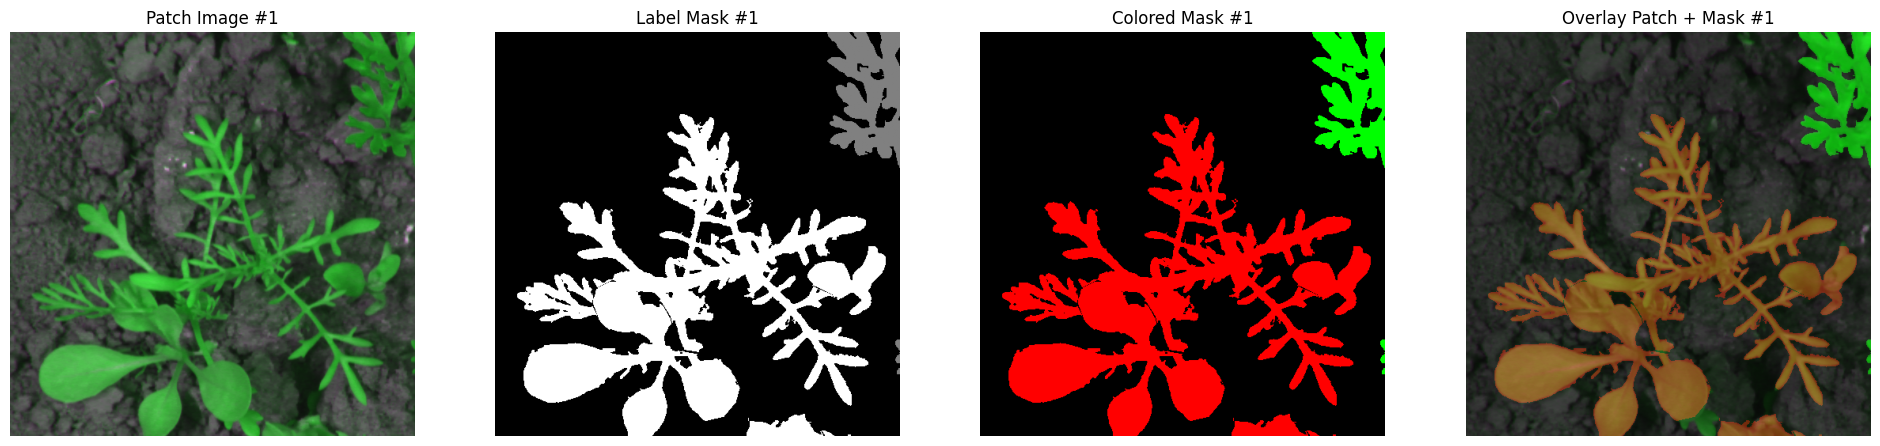

In [32]:
# Dari dataset patch loader (on-the-fly)
import matplotlib.pyplot as plt
visualize_dataset_sample(dataset, index=1)

In [67]:
from torch.utils.data import Subset
import numpy as np

import numpy as np
from torch.utils.data import Subset

def split_dataset(dataset, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1, shuffle=True):
    # FIX: Handle floating point precision!
    assert np.isclose(train_ratio + val_ratio + test_ratio, 1.0), "Total split ratio must be 1.0"

    dataset_size = len(dataset)
    indices = list(range(dataset_size))

    if shuffle:
        np.random.shuffle(indices)

    train_end = int(train_ratio * dataset_size)
    val_end = train_end + int(val_ratio * dataset_size)

    train_indices = indices[:train_end]
    val_indices = indices[train_end:val_end]
    test_indices = indices[val_end:]

    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)
    test_dataset = Subset(dataset, test_indices)

    print(f"Total Patches: {dataset_size}")
    print(f"Train Set  : {len(train_dataset)} patches ({train_ratio*100}%)")
    print(f"Valid Set  : {len(val_dataset)} patches ({val_ratio*100}%)")
    print(f"Test Set   : {len(test_dataset)} patches ({test_ratio*100}%)")

    return train_dataset, val_dataset, test_dataset

In [79]:
# Split ke train/val/test untuk disimpan pake dataset_raw
train_ds, val_ds, test_ds = split_dataset(dataset_raw, 0.7, 0.2, 0.1)

Total Patches: 480
Train Set  : 336 patches (70.0%)
Valid Set  : 96 patches (20.0%)
Test Set   : 48 patches (10.0%)


In [ ]:
train_dataset, val_dataset, test_dataset = split_dataset(dataset, 0.7, 0.2, 0.1)
# Loader train
train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

# Loader validasi
val_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# Loader test
test_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

In [ ]:
import matplotlib.pyplot as plt
visualize_dataset_sample(test_dataset, index=2)

#Save Split

In [74]:
import os

base_dir = os.path.join(pardir, "split_patch_dataset")
splits = ['train', 'val', 'test']

for split in splits:
    os.makedirs(os.path.join(base_dir, split, 'images'), exist_ok=True)
    os.makedirs(os.path.join(base_dir, split, 'masks'), exist_ok=True)


In [75]:
from torchvision.utils import save_image
from PIL import Image


In [76]:
from PIL import Image
from torchvision.transforms.functional import to_pil_image
import os
from tqdm import tqdm

def save_dataset(dataset, split_name, base_dir):
    split_path = os.path.join(base_dir, split_name)
    os.makedirs(os.path.join(split_path, 'images'), exist_ok=True)
    os.makedirs(os.path.join(split_path, 'masks'), exist_ok=True)

    for idx in tqdm(range(len(dataset)), desc=f"Saving {split_name}"):
        img, mask = dataset[idx]

        # Simpan image
        if isinstance(img, torch.Tensor):
            img_pil = to_pil_image(img)
        else:
            img_pil = img  # asumsi sudah PIL.Image

        # Simpan mask
        if isinstance(mask, torch.Tensor):
            mask_np = mask.numpy().astype('uint8')
        else:
            mask_np = np.array(mask).astype('uint8')

        mask_pil = Image.fromarray(mask_np, mode='L')

        img_pil.save(os.path.join(split_path, 'images', f"{split_name}_{idx:04d}.png"))
        mask_pil.save(os.path.join(split_path, 'masks', f"{split_name}_{idx:04d}.png"))


In [80]:
save_dataset(train_ds, 'train', base_dir)
save_dataset(val_ds, 'val', base_dir)
save_dataset(test_ds, 'test', base_dir)


Saving test: 100%|██████████| 48/48 [00:11<00:00,  4.31it/s]


#Load Split

##struktur

```
/content/drive/MyDrive/colab_indra/ss/split_dataset/
├── train/
│   ├── images/
│   └── masks/
├── val/
│   ├── images/
│   └── masks/
└── test/
    ├── images/
    └── masks/
```



##Load

In [82]:
from torch.utils.data import Dataset
from PIL import Image
import os
import numpy as np
import torchvision.transforms as T
import torch

class SegmentationFolderDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".png")])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.image_files[idx])  # nama sama

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # grayscale

        mask_np = np.array(mask).astype(np.uint8)

        if self.transform:
            augmented = self.transform(image=np.array(img), mask=mask_np)
            img = augmented["image"]
            mask = augmented["mask"]

        return img, torch.as_tensor(mask, dtype=torch.long)



In [83]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

test_transform = A.Compose([
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2(transpose_mask=True)
])


In [84]:
split_base = base_dir

train_datasetload = SegmentationFolderDataset(
    image_dir=os.path.join(split_base, "train", "images"),
    mask_dir=os.path.join(split_base, "train", "masks"),
    transform=test_transform
)

val_datasetload = SegmentationFolderDataset(
    image_dir=os.path.join(split_base, "val", "images"),
    mask_dir=os.path.join(split_base, "val", "masks"),
    transform=test_transform
)

test_datasetload = SegmentationFolderDataset(
    image_dir=os.path.join(split_base, "test", "images"),
    mask_dir=os.path.join(split_base, "test", "masks"),
    transform=test_transform
)


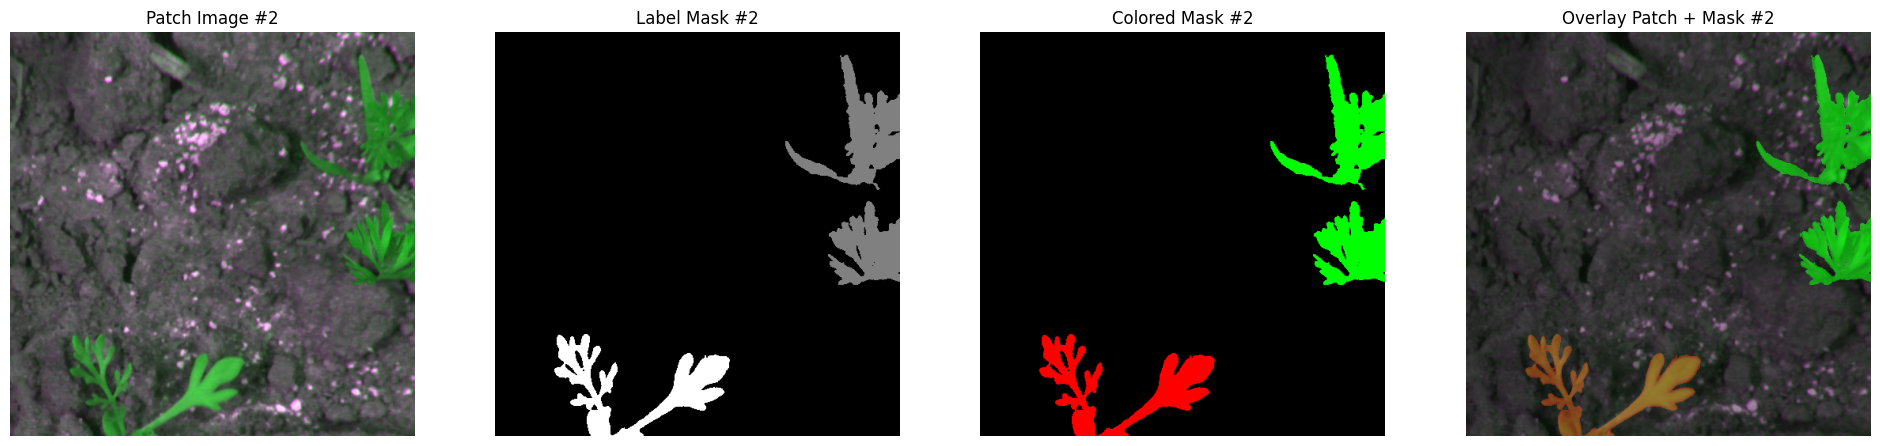

In [85]:
import matplotlib.pyplot as plt
visualize_dataset_sample(test_datasetload, index=2)

##Loader

In [86]:
from torch.utils.data import DataLoader

trainload_loader_ = DataLoader(train_datasetload, batch_size=4, shuffle=True)
valload_loader = DataLoader(val_datasetload, batch_size=4, shuffle=False)
testload_loader = DataLoader(test_datasetload, batch_size=4, shuffle=False)


#Evaluasi

In [87]:
def evaluate_all_metrics(model, loader, class_names=None, num_classes=3, dataset_name="Dataset", device='cuda'):
    model.eval()
    all_preds = []
    all_masks = []

    with torch.no_grad():
        for imgs, masks in loader:
            imgs = imgs.to(device)
            masks = masks.to(device)
            outputs_raw = model(imgs)
            outputs = outputs_raw[0] if isinstance(outputs_raw, (tuple, list)) else outputs_raw
            preds = torch.argmax(outputs, dim=1)
            all_preds.append(preds.cpu().numpy())
            all_masks.append(masks.cpu().numpy())

    all_preds = np.concatenate(all_preds).flatten()
    all_masks = np.concatenate(all_masks).flatten()

    precision_macro = precision_score(all_masks, all_preds, average='macro', zero_division=0)
    recall_macro = recall_score(all_masks, all_preds, average='macro', zero_division=0)
    f1_macro = f1_score(all_masks, all_preds, average='macro', zero_division=0)
    cm = confusion_matrix(all_masks, all_preds, labels=list(range(num_classes)))

    precision = precision_score(all_masks, all_preds, average=None, zero_division=0)
    recall = recall_score(all_masks, all_preds, average=None, zero_division=0)
    f1 = f1_score(all_masks, all_preds, average=None, zero_division=0)

    ious = []
    dices = []
    for cls in range(num_classes):
        tp = np.logical_and(all_preds == cls, all_masks == cls).sum()
        fp = np.logical_and(all_preds == cls, all_masks != cls).sum()
        fn = np.logical_and(all_preds != cls, all_masks == cls).sum()
        iou = tp / (tp + fp + fn + 1e-7)
        dice = 2 * tp / (2 * tp + fp + fn + 1e-7)
        ious.append(iou)
        dices.append(dice)

    pixel_acc = (all_preds == all_masks).sum() / len(all_masks)
    miou = np.mean(ious)
    mdice = np.mean(dices)

    print(f"\n📊 {dataset_name} Evaluation Summary")
    print(f"Overall Accuracy : {pixel_acc:.4f}")
    print(f"Precision (macro): {precision_macro:.4f}")
    print(f"Recall (macro)   : {recall_macro:.4f}")
    print(f"F1-Score (macro) : {f1_macro:.4f}")
    print(f"mIoU             : {miou:.4f}")
    print(f"mDice            : {mdice:.4f}")
    print(f"Confusion Matrix:\n{cm}")

    for i in range(num_classes):
        cname = class_names[i] if class_names else f"Class {i}"
        print(f"\n📌 {cname}")
        print(f"  IoU      : {ious[i]:.4f}")
        print(f"  Dice     : {dices[i]:.4f}")
        print(f"  Precision: {precision[i]:.4f}")
        print(f"  Recall   : {recall[i]:.4f}")
        print(f"  F1-Score : {f1[i]:.4f}")


#FastCNN

In [91]:
!git clone https://github.com/Tramac/Fast-SCNN-pytorch.git
%cd Fast-SCNN-pytorch
# Balik ke folder Fast-SCNN-pytorch repo
%cd /content/Fast-SCNN-pytorch

# Cek isi foldernya
!ls

Cloning into 'Fast-SCNN-pytorch'...
remote: Enumerating objects: 235, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 235 (delta 68), reused 65 (delta 65), pack-reused 156 (from 1)
Receiving objects: 100% (235/235), 8.71 MiB | 25.33 MiB/s, done.
Resolving deltas: 100% (121/121), done.
/content/Fast-SCNN-pytorch
/content/Fast-SCNN-pytorch
data_loader  eval.py  models  README.md  utils
demo.py      LICENSE  png     train.py	 weights


In [92]:
#Load Model
# Pindah ke repo (kalau belum)
%cd /content/Fast-SCNN-pytorch

# Tambah path repo ke sys.path
import sys
sys.path.append('/content/Fast-SCNN-pytorch')

# Import FastSCNN dari file fast_scnn.py di folder models
from models.fast_scnn import FastSCNN

# Setup student model
student_model = FastSCNN(num_classes=3)
student_model.to(device)

print("Student Model Loaded: Fast-SCNN ✅")

/content/Fast-SCNN-pytorch


NameError: name 'device' is not defined

In [88]:
# Ganti path sesuai lokasi file model terbaikmu
model_path = '/content/drive/MyDrive/colab_indra/ss/cwfid_new/KD03/best_student_model_iou.pth'

# Pastikan student_model dan test_loader sudah didefinisikan
student_model.load_state_dict(torch.load(model_path, map_location='cuda'))
student_model.to('cuda')

evaluate_all_metrics(student_model, test_loader, class_names=["BG", "Crop", "Weed"], dataset_name="Test Set", device='cuda')


NameError: name 'student_model' is not defined